## 人民币 二分类

```
实现 1 元人民币和 100 元人民币的图片二分类。前面讲过 PyTorch 的五大模块：数据、模型、损失函数、优化器和迭代训练。
数据模块又可以细分为 4 个部分：
数据收集：样本和标签。
数据划分：训练集、验证集和测试集
数据读取：对应于PyTorch 的 DataLoader。其中 DataLoader 包括 Sampler 和 DataSet。Sampler 的功能是生成索引， DataSet 是根据生成的索引读取样本以及标签。
数据预处理：对应于 PyTorch 的 transforms

### DataLoader 与 DataSet

```python
DataLoader()
torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, sampler=None, batch_sampler=None, num_workers=0, collate_fn=None, pin_memory=False, drop_last=False, timeout=0, worker_init_fn=None, multiprocessing_context=None)
```
```
功能：构建可迭代的数据装载器
dataset: Dataset 类，决定数据从哪里读取以及如何读取
batchsize: 批大小
num_works:num_works: 是否多进程读取数据
sheuffle: 每个 epoch 是否乱序
drop_last: 当样本数不能被 batchsize 整除时，是否舍弃最后一批数据

Epoch, Iteration, Batchsize
Epoch: 所有训练样本都已经输入到模型中，称为一个 Epoch
Iteration: 一批样本输入到模型中，称为一个 Iteration
Batchsize: 批大小，决定一个 iteration 有多少样本，也决定了一个 Epoch 有多少个 Iteration

```python
DataSet()
```
```
功能：Dataset 是抽象类，所有自定义的 Dataset 都需要继承该类，并且重写__getitem()__方法和__len__()方法 。__getitem()__方法的作用是接收一个索引，返回索引对应的样本和标签，这是我们自己需要实现的逻辑。__len__()方法是返回所有样本的数量。
数据读取包含 3 个方面
读取哪些数据：每个 Iteration 读取一个 Batchsize 大小的数据，每个 Iteration 应该读取哪些数据。
从哪里读取数据：如何找到硬盘中的数据，应该在哪里设置文件路径参数
如何读取数据：不同的文件需要使用不同的读取方法和库。

In [2]:
import os
import random
import shutil
import torch
from PIL import Image

import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import torchvision.transforms as transforms

from tensorboardX import  SummaryWriter
import matplotlib.pyplot as plt

/Users/tianyongliu/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/tianyongliu/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace '__ZN3c106detail19maybe_wrap_dim_slowExxb'
  warn(f"Failed to load image Python extension: {e}")


In [3]:
# 创建文件夹
def makedir(new_dir):
    if not os.path.exists(new_dir):
        os.makedirs(new_dir)

In [4]:
random.seed(1)

# 'data\\RMB_data'
dataset_dir = os.path.join("../data", "RMB_data")

# 'data\\rmb_split'
split_dir = os.path.join("data", "rmb_split")

# 'data\\rmb_split\\train'
train_dir = os.path.join(split_dir, "train")
# 'data\\rmb_split\\valid'
valid_dir = os.path.join(split_dir, "valid")
# 'data\\rmb_split\\test'
test_dir = os.path.join(split_dir, "test")

# 训练集
train_pct = 0.8
# 验证集
valid_pct = 0.1
# 测试集
test_pct = 0.1

In [5]:
dataset_dir

'../data/RMB_data'

In [6]:
# 划分训练集验证集 测试集
for root, dirs, files in os.walk(dataset_dir):
    # 文件列表
    # dirs: ['1', '100']
    for sub_dir in dirs:
        imgs = os.listdir(os.path.join(root, sub_dir))
        # 取出 jpg 结尾的文件
        imgs = list(filter(lambda x: x.endswith('.jpg'), imgs))
        random.shuffle(imgs)
        
        # 计算图片数量
        img_count = len(imgs)
        # 计算训练集索引的结束位置
        train_point = int(img_count * train_pct)
        # 计算验证集索引的结束位置
        valid_point = int(img_count * (train_pct + valid_pct))
        
        # 把数据划分到训练集、验证集、测试集的文件夹
        for i in range(img_count):
            if i < train_point:
                out_dir = os.path.join(train_dir, sub_dir)
            elif i < valid_point:
                out_dir = os.path.join(valid_dir, sub_dir)
            else:
                out_dir = os.path.join(test_dir, sub_dir)
                
            # 创建文件夹
            makedir(out_dir)
            # 构造目标文件名
            target_path = os.path.join(out_dir, imgs[i])
            # 构造源文件名
            src_path = os.path.join(dataset_dir, sub_dir, imgs[i])
            # 复制
            shutil.copy(src_path, target_path)
        print('Class:{}, train:{}, valid:{}, test:{}'.format(sub_dir, train_point, valid_point-train_point,
                                                                 img_count-valid_point))
        

Class:1, train:80, valid:10, test:10
Class:100, train:80, valid:10, test:10


In [7]:
random.seed(1)
rmb_label = {"1": 0, "100": 1}

class RMBDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        """
        rmb面额分类任务的Dataset
        :param data_dir: str, 数据集所在路径
        :param transform: torch.transform，数据预处理
        """
        # data_info存储所有图片路径和标签，在DataLoader中通过index读取样本
        self.data_info = self.get_img_info(data_dir)
        self.transform = transform

    def __getitem__(self, index):
        # 通过 index 读取样本
        path_img, label = self.data_info[index]
        # 注意这里需要 convert('RGB')
        img = Image.open(path_img).convert('RGB')     # 0~255
        if self.transform is not None:
            img = self.transform(img)   # 在这里做transform，转为tensor等等
        # 返回是样本和标签
        return img, label

    # 返回所有样本的数量
    def __len__(self):
        return len(self.data_info)

    @staticmethod
    def get_img_info(data_dir):
        data_info = list()
        # data_dir 是训练集、验证集或者测试集的路径
        for root, dirs, _ in os.walk(data_dir):
            # 遍历类别
            # dirs ['1', '100']
            for sub_dir in dirs:
                # 文件列表
                img_names = os.listdir(os.path.join(root, sub_dir))
                # 取出 jpg 结尾的文件
                img_names = list(filter(lambda x: x.endswith('.jpg'), img_names))
                # 遍历图片
                for i in range(len(img_names)):
                    img_name = img_names[i]
                    # 图片的绝对路径
                    path_img = os.path.join(root, sub_dir, img_name)
                    # 标签，这里需要映射为 0、1 两个类别
                    label = rmb_label[sub_dir]
                    # 保存在 data_info 变量中
                    data_info.append((path_img, int(label)))
        return data_info

In [8]:
class LeNet(nn.Module):
    # 子模块创建
    def __init__(self, classes):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, classes)

    # 子模块拼接
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight.data, 0, 0.1)
                m.bias.data.zero_()


class LeNetSequetial(nn.Module):
    def __init__(self, classes):
        super(LeNetSequetial, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(16*5*5, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size()[0], -1)
        x = self.classifier(x)
        return x

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight.data, 0, 0.1)
                m.bias.data.zero_()

In [9]:
# 设置随机种子
def set_seed(seed=1):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [10]:
set_seed(921)  # 设置随机种子
rmb_label = {"1": 0, "100": 1}

# 参数设置
MAX_EPOCH = 10
BATCH_SIZE = 16
LR = 0.01
log_interval = 10
val_interval = 1

In [11]:
# ============================ step 1/5 数据 ============================

# 设置路径参数
rmb_split_dir = 'data/rmb_split'

train_dir = os.path.join(rmb_split_dir, "train")
valid_dir = os.path.join(rmb_split_dir, "valid")

norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

In [12]:
# 设置训练集的数据增强和转化
train_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std),
])

# 设置验证集的数据增强和转化，不需要 RandomCrop
valid_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std),
])


In [13]:
# 构建MyDataset实例
train_data = RMBDataset(data_dir=train_dir, transform=train_transform)
valid_data = RMBDataset(data_dir=valid_dir, transform=valid_transform)


In [14]:
# 构建DataLoder
# 其中训练集设置 shuffle=True，表示每个 Epoch 都打乱样本
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(dataset=valid_data, batch_size=BATCH_SIZE)

In [15]:
# ============================ step 2/5 模型 ============================

net = LeNetSequetial(classes=2)
net.initialize_weights()


In [16]:
# ============================ step 3/5 损失函数 ============================

criterion = nn.CrossEntropyLoss()    # 选择损失函数

In [17]:
# ============================ step 4/5 优化器 ============================

optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.9)                        # 选择优化器
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)     # 设置学习率下降策略

In [18]:
# ============================ step 5/5 训练 ============================

train_curve = list()
valid_curve = list()

iter_count = 0

# 构建 SummaryWriter
writer = SummaryWriter(comment='test_your_comment', filename_suffix="_test_your_filename_suffix")

Training:Epoch[000/010] Iteration[010/013] Loss: 0.6164 Acc:78.12%
Valid:	 Epoch[000/010] Iteration[004/004] Loss: 1.0476 Acc:98.11%
Training:Epoch[001/010] Iteration[010/013] Loss: 0.0968 Acc:98.75%
Valid:	 Epoch[001/010] Iteration[004/004] Loss: 0.0007 Acc:100.00%
Training:Epoch[002/010] Iteration[010/013] Loss: 0.0017 Acc:100.00%
Valid:	 Epoch[002/010] Iteration[004/004] Loss: 0.0001 Acc:100.00%
Training:Epoch[003/010] Iteration[010/013] Loss: 0.0005 Acc:100.00%
Valid:	 Epoch[003/010] Iteration[004/004] Loss: 0.0000 Acc:100.00%
Training:Epoch[004/010] Iteration[010/013] Loss: 0.0000 Acc:100.00%
Valid:	 Epoch[004/010] Iteration[004/004] Loss: 0.0000 Acc:100.00%
Training:Epoch[005/010] Iteration[010/013] Loss: 0.0024 Acc:100.00%
Valid:	 Epoch[005/010] Iteration[004/004] Loss: 0.1968 Acc:98.11%
Training:Epoch[006/010] Iteration[010/013] Loss: 0.0461 Acc:99.38%
Valid:	 Epoch[006/010] Iteration[004/004] Loss: 0.0031 Acc:100.00%
Training:Epoch[007/010] Iteration[010/013] Loss: 1.5391 Acc:

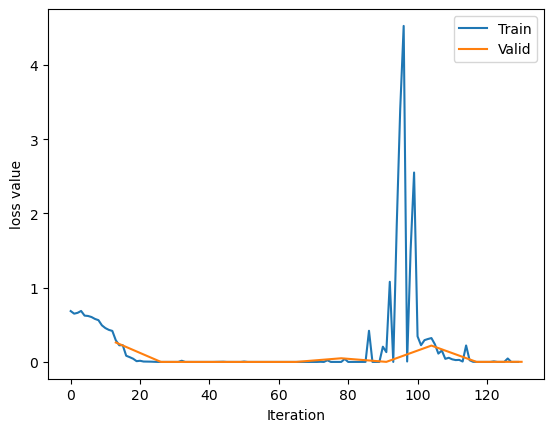

In [19]:
for epoch in range(MAX_EPOCH):

    loss_mean = 0.
    correct = 0.
    total = 0.

    net.train()
    # 遍历 train_loader 取数据
    for i, data in enumerate(train_loader):
        iter_count += 1
        # forward
        inputs, labels = data
        outputs = net(inputs)

        # backward
        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        loss.backward()

        # update weights
        optimizer.step()

        # 统计分类情况
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).squeeze().sum().numpy()

        # 打印训练信息
        loss_mean += loss.item()
        train_curve.append(loss.item())
        if (i+1) % log_interval == 0:
            loss_mean = loss_mean / log_interval
            print("Training:Epoch[{:0>3}/{:0>3}] Iteration[{:0>3}/{:0>3}] Loss: {:.4f} Acc:{:.2%}".format(
                epoch, MAX_EPOCH, i+1, len(train_loader), loss_mean, correct / total))
            loss_mean = 0.

        # 记录数据，保存于event file
        writer.add_scalars("Loss", {"Train": loss.item()}, iter_count)
        writer.add_scalars("Accuracy", {"Train": correct / total}, iter_count)

    # 每个epoch，记录梯度，权值
    for name, param in net.named_parameters():
        writer.add_histogram(name + '_grad', param.grad, epoch)
        writer.add_histogram(name + '_data', param, epoch)

    scheduler.step()  # 每个 epoch 更新学习率
    # 每个 epoch 计算验证集得准确率和loss
    # validate the model
    if (epoch+1) % val_interval == 0:

        correct_val = 0.
        total_val = 0.
        loss_val = 0.
        net.eval()
        with torch.no_grad():
            for j, data in enumerate(valid_loader):
                inputs, labels = data
                outputs = net(inputs)
                loss = criterion(outputs, labels)

                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).squeeze().sum().numpy()

                loss_val += loss.item()

            valid_curve.append(loss_val/valid_loader.__len__())
            print("Valid:\t Epoch[{:0>3}/{:0>3}] Iteration[{:0>3}/{:0>3}] Loss: {:.4f} Acc:{:.2%}".format(
                epoch, MAX_EPOCH, j+1, len(valid_loader), loss_val, correct_val / total_val))

            # 记录数据，保存于event file
            writer.add_scalars("Loss", {"Valid": np.mean(valid_curve)}, iter_count)
            writer.add_scalars("Accuracy", {"Valid": correct / total}, iter_count)

train_x = range(len(train_curve))
train_y = train_curve

train_iters = len(train_loader)
valid_x = np.arange(1, len(valid_curve)+1) * train_iters*val_interval # 由于valid中记录的是epochloss，需要对记录点进行转换到iterations
valid_y = valid_curve

plt.plot(train_x, train_y, label='Train')
plt.plot(valid_x, valid_y, label='Valid')

plt.legend(loc='upper right')
plt.ylabel('loss value')
plt.xlabel('Iteration')
plt.show()